# Date: 9 2022
# Method: Cross_Inception
# Data: Pavia
# Results v.05

In [30]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA


In [31]:
# Read dataset Pavia
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [32]:
# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

In [33]:
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [34]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [35]:
# Split Data
from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [36]:
test_ratio = 0.5

# Load and reshape data for training
X0, y0 = read_HSI()
#X=X0
#y=y0

windowSize=13
width = windowSize
height = windowSize
img_width, img_height, img_num_channels = windowSize, windowSize, 3

input_image_size=windowSize
INPUT_IMG_SIZE=windowSize

dimReduction=3

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


X shape: (610, 340, 103)
y shape: (610, 340)
(207400, 103)


In [37]:
# Compile the model
#incept_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
print()

import warnings
warnings.filterwarnings("ignore")

# load libraries
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
import numpy as np



In [39]:
# 9 classes names
names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']

In [40]:
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import densenet, inception_v3, mobilenet, resnet, vgg16, vgg19, xception

model = EfficientNetB0(weights='imagenet')


def build_model(num_classes):
    inputs = layers.Input(shape=(windowSize, windowSize, 3))
    #x = img_augmentation(inputs)
    model =  resnet.ResNet50(include_top=False,  input_tensor=inputs, weights="imagenet")
    #model1 = resnet.ResNet50(weights='imagenet')


    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(9, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [41]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [42]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
250/250 - 17s - loss: 0.9803 - accuracy: 0.6746 - val_loss: 0.9371 - val_accuracy: 0.6450 - 17s/epoch - 67ms/step
Epoch 2/20
250/250 - 13s - loss: 0.7388 - accuracy: 0.7596 - val_loss: 0.6362 - val_accuracy: 0.8100 - 13s/epoch - 53ms/step
Epoch 3/20
250/250 - 12s - loss: 0.6729 - accuracy: 0.7761 - val_loss: 0.5616 - val_accuracy: 0.8235 - 12s/epoch - 46ms/step
Epoch 4/20
250/250 - 11s - loss: 0.6287 - accuracy: 0.7903 - val_loss: 0.5260 - val_accuracy: 0.8345 - 11s/epoch - 44ms/step
Epoch 5/20
250/250 - 11s - loss: 0.6079 - accuracy: 0.7943 - val_loss: 0.5044 - val_accuracy: 0.8395 - 11s/epoch - 44ms/step
Epoch 6/20
250/250 - 11s - loss: 0.6048 - accuracy: 0.7952 - val_loss: 0.4821 - val_accuracy: 0.8480 - 11s/epoch - 44ms/step
Epoch 7/20
250/250 - 11s - loss: 0.5860 - accuracy: 0.8002 - val_loss: 0.4729 - val_accuracy: 0.8435 - 11s/epoch - 44ms/step
Epoch 8/20
250/250 - 11s - l

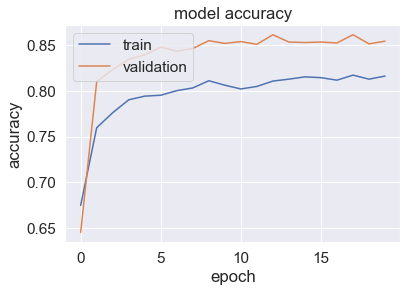

Score for fold 1: loss of 0.42023709416389465; accuracy of 85.44999957084656%
63/63 [==============================] - 3s 42ms/step
[[241  15   5   1   0  10   4  18   0]
 [  7 856   1   0   0   9   0   2   0]
 [ 12   2  53   0   0   3   5  15   0]
 [  5   3   0 141   0   2   0   1   2]
 [  0   0   0   0  72   0   0   0   0]
 [  3  89   0   2   0 128   2   8   0]
 [  9   9   1   3   0   7  24   4   0]
 [ 16   0   4   1   0   1   4 159   0]
 [  0   0   0   3   0   1   0   2  35]]
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
250/250 - 15s - loss: 0.9684 - accuracy: 0.6808 - val_loss: 0.9052 - val_accuracy: 0.6930 - 15s/epoch - 58ms/step
Epoch 2/20
250/250 - 13s - loss: 0.7167 - accuracy: 0.7699 - val_loss: 0.6814 - val_accuracy: 0.7835 - 13s/epoch - 50ms/step
Epoch 3/20
250/250 - 13s - loss: 0.6569 - accuracy: 0.7826 - val_loss: 0.6078 - val_accuracy: 0.7990 - 13s/epoch - 50ms/step
Epoch 4/20
250/250 - 13s - loss: 0.6016 - ac

<Figure size 432x288 with 0 Axes>

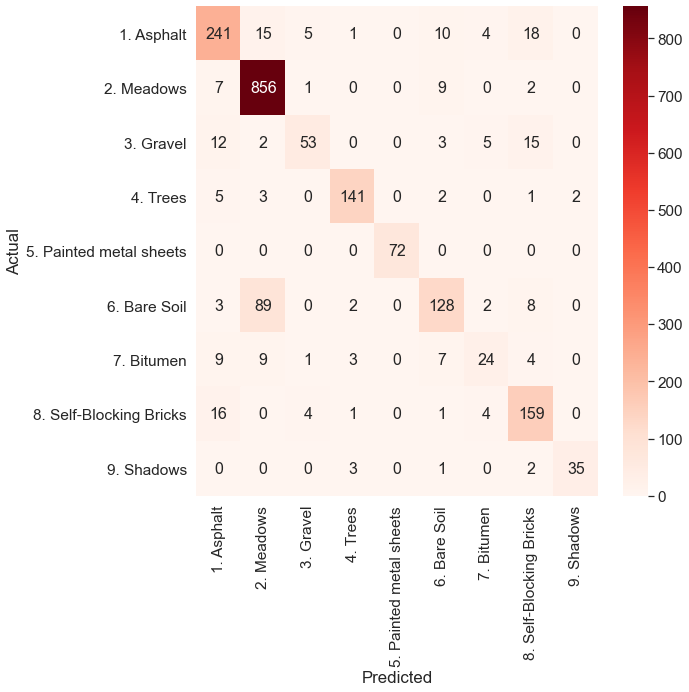

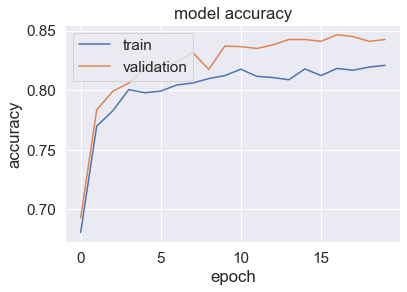

Score for fold 2: loss of 0.47281187772750854; accuracy of 84.24999713897705%
63/63 [==============================] - 6s 64ms/step
[[283  12  12   2   0   1   1  10   0]
 [  4 835   1   1   0  14   2   0   0]
 [ 18   5  59   0   0   4   3  15   2]
 [  8   3   1 130   0   2   2   1   1]
 [  0   0   0   0  64   0   0   0   0]
 [ 13  96   5   1   0 143   5   1   0]
 [  8   8   2   1   0   6  26   0   0]
 [ 27   0   8   0   0   1   6 114   0]
 [  0   0   0   2   0   0   0   0  31]]
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
250/250 - 18s - loss: 0.9712 - accuracy: 0.6806 - val_loss: 0.9369 - val_accuracy: 0.6535 - 18s/epoch - 72ms/step
Epoch 2/20
250/250 - 16s - loss: 0.7193 - accuracy: 0.7660 - val_loss: 0.6968 - val_accuracy: 0.7665 - 16s/epoch - 65ms/step
Epoch 3/20
250/250 - 17s - loss: 0.6629 - accuracy: 0.7830 - val_loss: 0.6118 - val_accuracy: 0.7940 - 17s/epoch - 68ms/step
Epoch 4/20
250/250 - 15s - loss: 0.6219 - ac

<Figure size 432x288 with 0 Axes>

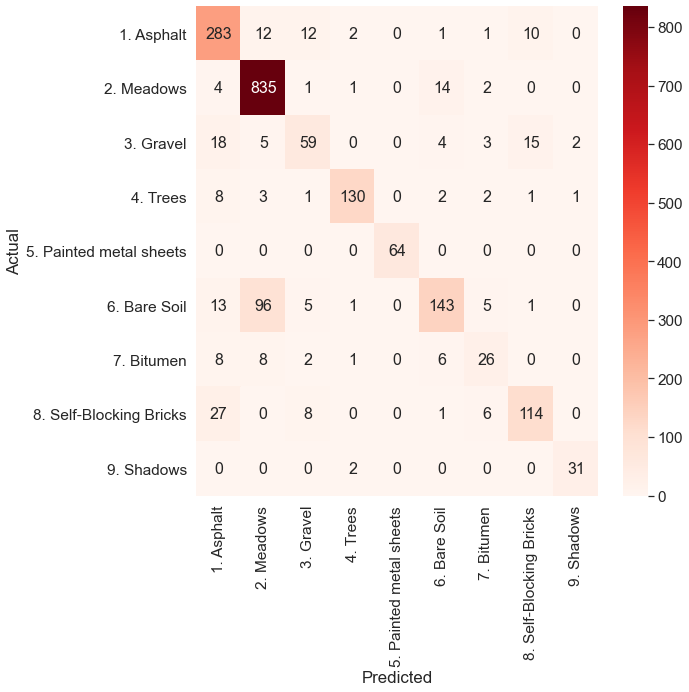

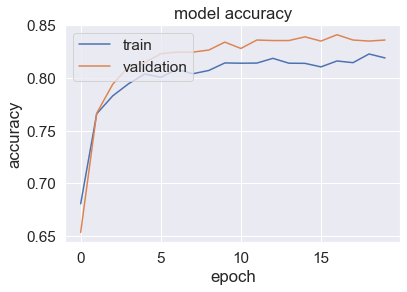

Score for fold 3: loss of 0.49239838123321533; accuracy of 83.60000252723694%
63/63 [==============================] - 3s 40ms/step
[[251  26   8   0   0   7   5  20   0]
 [  5 828   2   1   0   5   2   1   0]
 [ 14   1  60   1   0   2   2  12   0]
 [  3   1   0 144   1   0   2   0   0]
 [  0   0   0   0  66   0   0   0   1]
 [ 15  87  11   1   0 118   3   5   0]
 [  7   7   1   6   0   6  36   6   2]
 [ 33   0  11   2   0   0   1 135   0]
 [  0   0   0   0   0   2   0   0  34]]
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
250/250 - 14s - loss: 0.9710 - accuracy: 0.6823 - val_loss: 0.9462 - val_accuracy: 0.6395 - 14s/epoch - 56ms/step
Epoch 2/20
250/250 - 14s - loss: 0.7219 - accuracy: 0.7697 - val_loss: 0.6536 - val_accuracy: 0.7850 - 14s/epoch - 56ms/step
Epoch 3/20
250/250 - 15s - loss: 0.6448 - accuracy: 0.7915 - val_loss: 0.5922 - val_accuracy: 0.8075 - 15s/epoch - 61ms/step
Epoch 4/20
250/250 - 16s - loss: 0.6202 - ac

<Figure size 432x288 with 0 Axes>

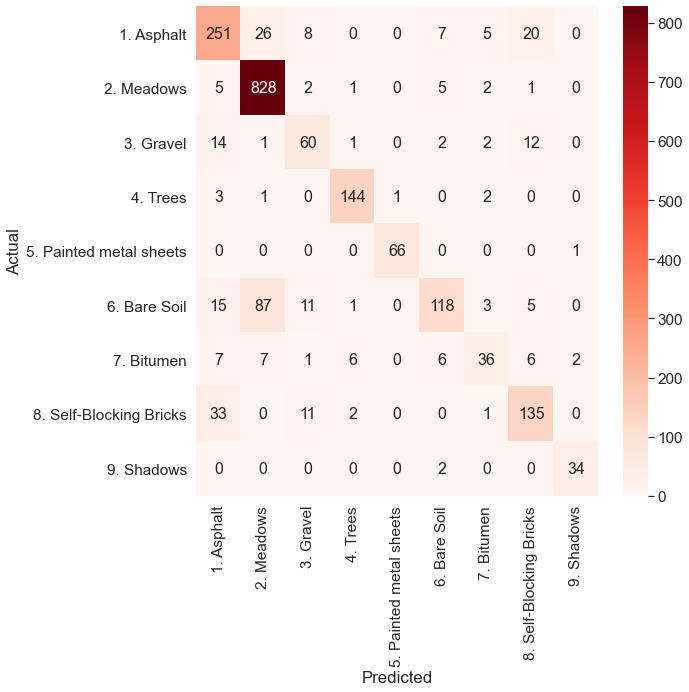

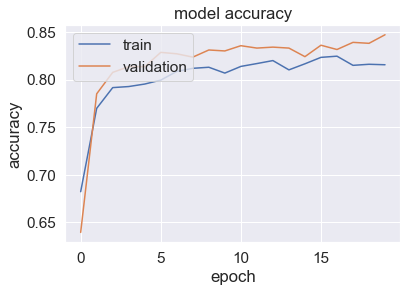

Score for fold 4: loss of 0.46209317445755005; accuracy of 84.7000002861023%
63/63 [==============================] - 4s 60ms/step
[[238  19   2   0   0   5   5  23   0]
 [  7 848   2   1   0  24   0   1   0]
 [ 14   1  60   0   0   1   4  23   0]
 [  3   4   0 120   0   1   0   0   1]
 [  0   0   0   0  67   0   0   0   0]
 [ 11  77   1   3   0 119   3   6   0]
 [  6   4   3   1   0   7  29   8   1]
 [ 17   0  10   0   0   0   2 171   0]
 [  1   0   0   3   1   0   0   0  42]]
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
250/250 - 17s - loss: 0.9828 - accuracy: 0.6771 - val_loss: 0.9541 - val_accuracy: 0.6790 - 17s/epoch - 68ms/step
Epoch 2/20
250/250 - 14s - loss: 0.7224 - accuracy: 0.7632 - val_loss: 0.6731 - val_accuracy: 0.7785 - 14s/epoch - 58ms/step
Epoch 3/20
250/250 - 14s - loss: 0.6612 - accuracy: 0.7805 - val_loss: 0.5939 - val_accuracy: 0.8100 - 14s/epoch - 56ms/step
Epoch 4/20
250/250 - 14s - loss: 0.6270 - acc

<Figure size 432x288 with 0 Axes>

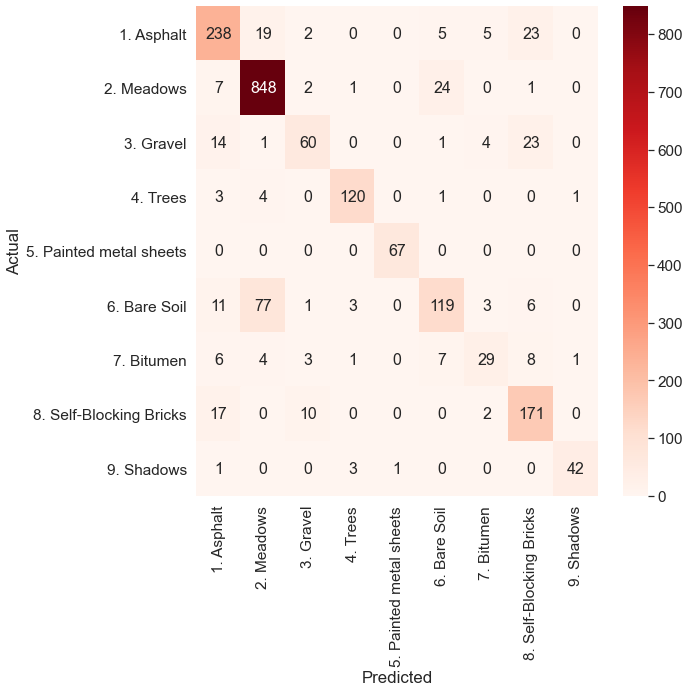

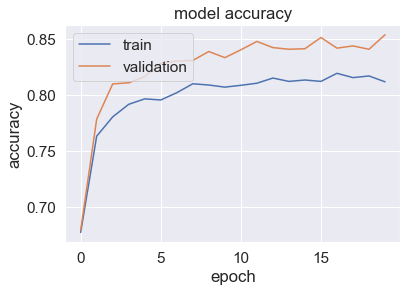

Score for fold 5: loss of 0.44121915102005005; accuracy of 85.39999723434448%
63/63 [==============================] - 4s 46ms/step
[[254   7   2   0   0   7   4  11   0]
 [  3 842   1   1   0  11   0   1   0]
 [ 25   3  48   0   0   2   3  25   0]
 [  3   2   0 143   0   5   0   3   2]
 [  0   0   0   0  60   0   0   0   0]
 [ 11  68   1   6   0 149   1   5   0]
 [ 19   5   0   9   0   6  29   7   0]
 [ 19   0   2   2   0   3   2 146   0]
 [  1   0   0   4   0   0   0   0  37]]
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.42023709416389465 - Accuracy: 85.44999957084656%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.47281187772750854 - Accuracy: 84.24999713897705%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.49239838123321533 - Accuracy: 83.60000252723694%
-----

<Figure size 432x288 with 0 Axes>

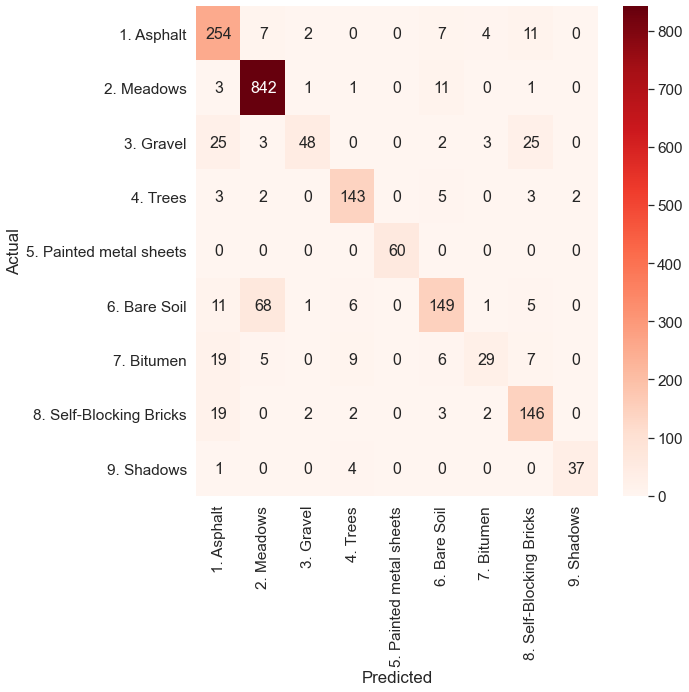

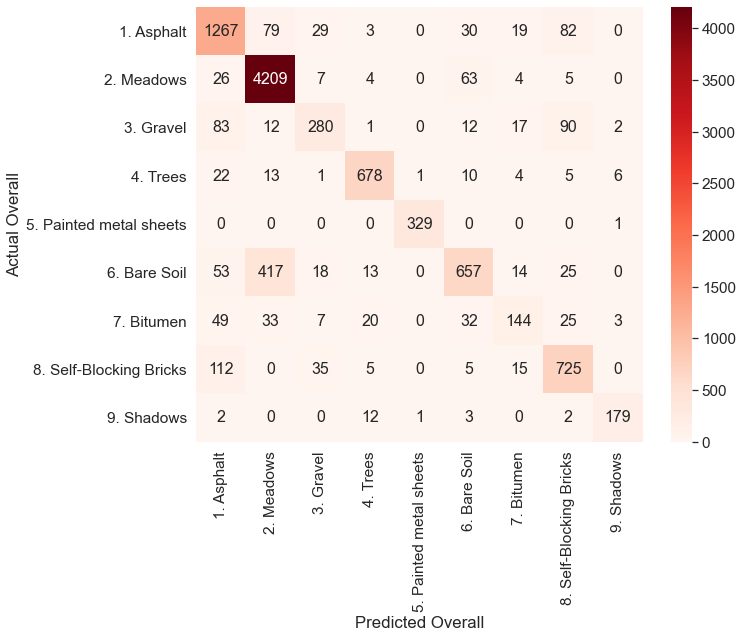

In [43]:

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras import layers

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model

import tensorflow as tf

# configuration
confmat = 0
batch_size = 50
loss_function = sparse_categorical_crossentropy
no_classes = 9
no_epochs = 20
optimizer = Adam()
verbosity = 1
num_folds = 5

NN=len(Xtrain)
NN=5000

input_train=Xtrain[0:NN]
target_train=ytrain[0:NN]

input_test=Xtest[0:NN]
target_test=ytest[0:NN]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
#input_train = input_train.astype('float32')
#input_test = input_test.astype('float32')

# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Y_pred=[]
y_pred=[]
# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  #  model architecture

  # Compile the model
  #model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

   # Compile the model
 # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  model = build_model(num_classes=9)
  #model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])

  #model.summary()

  #unfreeze_model(model)
  model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  #model.summary()
  
  history = model.fit(inputs[train], targets[train],
              validation_data = (inputs[test],targets[test]),
              epochs=no_epochs,verbose=2 )
  plt.figure()
  plot_hist(history)
 # hist = model.fit(inputs[train], targets[train],
   #                 steps_per_epoch=(29943/batch_size),
   #                 epochs=5,
   #                 validation_data=(inputs[test],targets[test]),
   #                 validation_steps=(8000/batch_size),
   #                 initial_epoch=20,
   #                 verbose=1 )
  plt.figure()
    


  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test],verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # confusion_matrix
  Y_pred = model.predict(inputs[test])
  y_pred = np.argmax(Y_pred, axis=1)
  #target_test=targets[test]

  confusion = confusion_matrix(targets[test], y_pred)
  df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (9,9))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
  plt.savefig('cmap.png', dpi=300)
  print(confusion_matrix(targets[test], y_pred))

  confmat    = confmat + confusion; 
  

  # Increase fold number
  fold_no = fold_no + 1

# == average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Overall_Conf = pd.DataFrame(confmat, columns=np.unique(names), index = np.unique(names))
Overall_Conf.index.name = 'Actual Overall'
Overall_Conf.columns.name = 'Predicted Overall'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(Overall_Conf, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(Overall_Conf)
